# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the network flow dataset.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/scratch/sj2363/hsn/attack_generate/gan_attack_generate/.env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from importlib import reload
import os
import utils, models
reload(utils)
reload(models)
from utils import model_inputs, get_flow_dataset
from models import generator, discriminator

In [3]:
(benign_train, benign_test), (attack_train, attack_test) = get_flow_dataset(os.path.join('data', 'ids2017_sampled.csv'))

/scratch/sj2363/hsn/attack_generate/gan_attack_generate/.env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [4]:
benign_train.shape

(1500, 47)

In [5]:
benign_test.shape

(3500, 47)

In [6]:
attack_train.shape

(1650, 47)

In [7]:
attack_test.shape

(3850, 47)

## Hyperparameters

In [8]:
# Size of input flow to discriminator
input_size = benign_train.shape[1]
# Size of latent vector to generator
z_size = 2
# Sizes of hidden layers in generator and discriminator
g_hidden_size = [128, 64]
d_hidden_size = [128, 64]
# Leak factor for leaky ReLU
alpha = 0.01

## Build network

Now we're building the network from the functions defined above.

First is to get our inputs, `input_benign, input_z, input_attack_remains` from `model_inputs` using the sizes of the input and z.

Then, we'll create the generator, `generator(input_z, z_size)`. This builds the generator with the appropriate input and output sizes.

Then the discriminators. We'll build two of them, one for benign flow data and one for attack flow data. Since we want the weights to be the same for both benign and attack flow data, we need to reuse the variables. For the attack flow data, we're getting it from the output of the generator concatenated with remaining part of attack feature called `g_model`. So the benign data discriminator is `discriminator(input_benign)` while the attack discriminator is `discriminator(g_model, reuse=True)`.

In [9]:
tf.reset_default_graph()

# Create our input placeholders
input_benign, input_z, input_attack_remains = model_inputs(input_size, z_size, attack_remains_dim=input_size - z_size)

# Build the model
z_generated, g_hidden = generator(input_z, z_size, n_units=[z_size] + g_hidden_size, alpha=alpha)
g_model = tf.concat([z_generated, input_attack_remains], 1)
# g_model is the generator output concatenated with the remaining part of attack features

d_model_benign, d_logits_benign, d_hidden_benign = discriminator(input_benign,
                                                                 n_units= [input_size] + d_hidden_size,
                                                                 alpha=alpha)
d_model_attack, d_logits_attack, d_hidden_attack = discriminator(g_model,
                                                                 reuse=True,
                                                                 n_units=[input_size] + d_hidden_size,
                                                                 alpha=alpha)

## Discriminator and Generator Losses

Now we need to calculate the losses, which is a little tricky. For the discriminator, the total loss is the sum of the losses for benign and attack flows, `d_loss = d_loss_benign + d_loss_attack`. The losses will by sigmoid cross-entropys, which we can get with `tf.nn.sigmoid_cross_entropy_with_logits`. We'll also wrap that in `tf.reduce_mean` to get the mean for all the flows in the batch. So the losses will look something like 

```python
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
```

For the benign flow logits, we'll use `d_logits_benign` which we got from the discriminator in the cell above. For the labels, we want them to be all zeros, since these are all benign flows. In TensorFlow, it looks something like `labels = tf.zeros_like(tensor)`

The discriminator loss for the attack flow data is similar. The logits are `d_logits_attack`, which we got from passing the generator output concatenated with remaing part of attack flow features to the discriminator. These attack logits are used with labels of all ones. Remember that we want the discriminator to output 0 for benign flows and 1 for attack flows, so we need to set up the losses to reflect that.

Finally, the generator losses are using `d_logits_attack`, the attack flow logits. But, now the labels are all zeros. The generator is trying to fool the discriminator, so it wants to discriminator to output zeros for attack flows.

In [10]:
# Calculate losses
d_loss_benign = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_benign, 
                                                          labels=tf.zeros_like(d_logits_benign)))
d_loss_attack = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_attack, 
                                                          labels=tf.ones_like(d_logits_attack)))
d_loss = d_loss_benign + d_loss_attack

g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_attack,
                                                     labels=tf.zeros_like(d_logits_attack)))

## Optimizers

We want to update the generator and discriminator variables separately. So we need to get the variables for each part build optimizers for the two parts. To get all the trainable variables, we use `tf.trainable_variables()`. This creates a list of all the variables we've defined in our graph.

For the generator optimizer, we only want to generator variables. Our past selves were nice and used a variable scope to start all of our generator variable names with `generator`. So, we just need to iterate through the list from `tf.trainable_variables()` and keep variables to start with `generator`. Each variable object has an attribute `name` which holds the name of the variable as a string (`var.name == 'weights_0'` for instance). 

We can do something similar with the discriminator. All the variables in the discriminator start with `discriminator`.

Then, in the optimizer we pass the variable lists to `var_list` in the `minimize` method. This tells the optimizer to only update the listed variables. Something like `tf.train.AdamOptimizer().minimize(loss, var_list=var_list)` will only train the variables in `var_list`.

In [11]:
# Optimizers
learning_rate = 0.002

# Get the trainable_variables, split into G and D parts
t_vars = tf.trainable_variables()
g_vars = [var for var in t_vars if var.name.startswith('generator')]
d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

## Training

In [12]:
from copy import deepcopy
import time

batch_size = 100
epochs = 1000
losses = []
original_flows, generated_flows, attack_scores = [], [], []
# Only save generator variables
saver = tf.train.Saver(var_list=g_vars)
# TODO: add outer-loop, which is test number, to see convergence trends
# TODO: modify training process - choose random 2 features and give 2 outputs randomly back
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    init_benign_test_score = sess.run(d_model_benign, feed_dict={input_benign: benign_test})
    init_attack_test_score = sess.run(d_model_benign, feed_dict={input_benign: attack_test})
    for e in range(epochs):
        start = time.time()
        np.random.shuffle(benign_train)
        np.random.shuffle(attack_train)
        original_flows.append([])
        generated_flows.append([])
        attack_scores.append([])
        for ii in range(benign_train.shape[0]//batch_size):
            batch_benign = benign_train[ii * batch_size:(ii + 1) * batch_size]
            
            batch_attack = attack_train[ii * batch_size:(ii + 1) * batch_size]
            batch_z = batch_attack[:,:z_size]
            batch_attack_remains = batch_attack[:,z_size:]
            
            if ii % 5 == 0:
                original_flow = batch_attack
                generated_flow = sess.run(g_model, feed_dict={input_z: batch_z, input_attack_remains: batch_attack_remains})
                attack_score = sess.run(d_model_attack, feed_dict={input_z: batch_z, input_attack_remains: batch_attack_remains})
                original_flows[-1].append(deepcopy(original_flow[0]))
                generated_flows[-1].append(generated_flow[0])
                attack_scores[-1].append(attack_score[0][0])
                
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={input_benign: batch_benign, input_z: batch_z, input_attack_remains: batch_attack_remains})
            _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_attack_remains: batch_attack_remains})
        
        # At the end of each epoch, get the losses and print them out
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_benign: batch_benign, input_attack_remains: batch_attack_remains})
        train_loss_g = g_loss.eval({input_z: batch_z, input_attack_remains: batch_attack_remains})
            
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g),
              "Time elapsed: {:.4f}".format(time.time() - start)
             )    
        # Save losses to view after training
        losses.append((train_loss_d, train_loss_g))
        
        saver.save(sess, './checkpoints/generator.ckpt')
    
    final_benign_test_score = sess.run(d_model_benign, feed_dict={input_benign: benign_test})
    final_attack_test_score = sess.run(d_model_benign, feed_dict={input_benign: attack_test})

Epoch 1/1000... Discriminator Loss: 48058.3673... Generator Loss: 2934028.9269 Time elapsed: 0.4162
Epoch 2/1000... Discriminator Loss: 19708.5949... Generator Loss: 1815194.8333 Time elapsed: 0.0756
Epoch 3/1000... Discriminator Loss: 32657.0525... Generator Loss: 2210118.2409 Time elapsed: 0.0877
Epoch 4/1000... Discriminator Loss: 19626.7644... Generator Loss: 2190845.2904 Time elapsed: 0.0780
Epoch 5/1000... Discriminator Loss: 11362.8461... Generator Loss: 2034384.0535 Time elapsed: 0.0929
Epoch 6/1000... Discriminator Loss: 4658.4310... Generator Loss: 2392488.9134 Time elapsed: 0.0867
Epoch 7/1000... Discriminator Loss: 14393.7545... Generator Loss: 2191973.1128 Time elapsed: 0.0815
Epoch 8/1000... Discriminator Loss: 6874.2423... Generator Loss: 1775429.4077 Time elapsed: 0.0766
Epoch 9/1000... Discriminator Loss: 3018.7078... Generator Loss: 1211916.0814 Time elapsed: 0.0779
Epoch 10/1000... Discriminator Loss: 10587.5931... Generator Loss: 1814597.5249 Time elapsed: 0.0793
Ep

Epoch 85/1000... Discriminator Loss: 4829.1838... Generator Loss: 2748154.3149 Time elapsed: 0.0791
Epoch 86/1000... Discriminator Loss: 3431.8258... Generator Loss: 1791364.6817 Time elapsed: 0.0792
Epoch 87/1000... Discriminator Loss: 619.4326... Generator Loss: 2948253.6864 Time elapsed: 0.0720
Epoch 88/1000... Discriminator Loss: 3352.8235... Generator Loss: 2622574.3782 Time elapsed: 0.0755
Epoch 89/1000... Discriminator Loss: 1498.5731... Generator Loss: 2522854.1055 Time elapsed: 0.0764
Epoch 90/1000... Discriminator Loss: 0.0000... Generator Loss: 2638668.7637 Time elapsed: 0.0805
Epoch 91/1000... Discriminator Loss: 0.0000... Generator Loss: 2583144.3753 Time elapsed: 0.0811
Epoch 92/1000... Discriminator Loss: 3238.3053... Generator Loss: 1819627.9649 Time elapsed: 0.0777
Epoch 93/1000... Discriminator Loss: 0.0000... Generator Loss: 1925138.4481 Time elapsed: 0.0767
Epoch 94/1000... Discriminator Loss: 842.6279... Generator Loss: 1045528.6523 Time elapsed: 0.0785
Epoch 95/10

Epoch 168/1000... Discriminator Loss: 1777.4314... Generator Loss: 2213033.4056 Time elapsed: 0.0818
Epoch 169/1000... Discriminator Loss: 2251.0055... Generator Loss: 1532925.3723 Time elapsed: 0.0748
Epoch 170/1000... Discriminator Loss: 0.0000... Generator Loss: 2559039.3398 Time elapsed: 0.0754
Epoch 171/1000... Discriminator Loss: 1217.5414... Generator Loss: 1857125.0414 Time elapsed: 0.0791
Epoch 172/1000... Discriminator Loss: 778.0607... Generator Loss: 1910243.6556 Time elapsed: 0.0788
Epoch 173/1000... Discriminator Loss: 706.0329... Generator Loss: 1144381.1869 Time elapsed: 0.0777
Epoch 174/1000... Discriminator Loss: 0.0000... Generator Loss: 1767052.7638 Time elapsed: 0.0747
Epoch 175/1000... Discriminator Loss: 0.0000... Generator Loss: 2013945.8839 Time elapsed: 0.0751
Epoch 176/1000... Discriminator Loss: 5319.7076... Generator Loss: 2095410.9136 Time elapsed: 0.0863
Epoch 177/1000... Discriminator Loss: 0.0000... Generator Loss: 2356380.3070 Time elapsed: 0.0795
Epoc

Epoch 251/1000... Discriminator Loss: 3061.6517... Generator Loss: 833030.0013 Time elapsed: 0.0774
Epoch 252/1000... Discriminator Loss: 337.3777... Generator Loss: 1119521.1684 Time elapsed: 0.0851
Epoch 253/1000... Discriminator Loss: 0.0000... Generator Loss: 1104226.6695 Time elapsed: 0.0898
Epoch 254/1000... Discriminator Loss: 0.0000... Generator Loss: 1575493.5514 Time elapsed: 0.0838
Epoch 255/1000... Discriminator Loss: 681.0610... Generator Loss: 924492.8813 Time elapsed: 0.0828
Epoch 256/1000... Discriminator Loss: 0.0000... Generator Loss: 1503986.5486 Time elapsed: 0.0758
Epoch 257/1000... Discriminator Loss: 306.8358... Generator Loss: 689300.7810 Time elapsed: 0.0776
Epoch 258/1000... Discriminator Loss: 0.0000... Generator Loss: 952490.1562 Time elapsed: 0.0777
Epoch 259/1000... Discriminator Loss: 417.8653... Generator Loss: 687846.8855 Time elapsed: 0.0715
Epoch 260/1000... Discriminator Loss: 175.0833... Generator Loss: 920906.5473 Time elapsed: 0.0753
Epoch 261/100

Epoch 334/1000... Discriminator Loss: 0.0000... Generator Loss: 1062601.6929 Time elapsed: 0.0708
Epoch 335/1000... Discriminator Loss: 262.1910... Generator Loss: 799487.2574 Time elapsed: 0.0804
Epoch 336/1000... Discriminator Loss: 0.0000... Generator Loss: 724399.0528 Time elapsed: 0.0710
Epoch 337/1000... Discriminator Loss: 65.8164... Generator Loss: 703906.1072 Time elapsed: 0.0781
Epoch 338/1000... Discriminator Loss: 0.0000... Generator Loss: 852111.8811 Time elapsed: 0.0763
Epoch 339/1000... Discriminator Loss: 175.9657... Generator Loss: 870770.0283 Time elapsed: 0.0766
Epoch 340/1000... Discriminator Loss: 0.0000... Generator Loss: 863141.2660 Time elapsed: 0.0787
Epoch 341/1000... Discriminator Loss: 74.4830... Generator Loss: 867527.8622 Time elapsed: 0.0797
Epoch 342/1000... Discriminator Loss: 126.8725... Generator Loss: 840823.1607 Time elapsed: 0.0764
Epoch 343/1000... Discriminator Loss: 132.6945... Generator Loss: 746671.5413 Time elapsed: 0.0737
Epoch 344/1000... D

Epoch 419/1000... Discriminator Loss: 106.0345... Generator Loss: 700225.0499 Time elapsed: 0.0781
Epoch 420/1000... Discriminator Loss: 116.4154... Generator Loss: 719021.3577 Time elapsed: 0.0728
Epoch 421/1000... Discriminator Loss: 0.0000... Generator Loss: 699668.8269 Time elapsed: 0.0764
Epoch 422/1000... Discriminator Loss: 260.1982... Generator Loss: 399302.2139 Time elapsed: 0.0734
Epoch 423/1000... Discriminator Loss: 111.7042... Generator Loss: 586548.3199 Time elapsed: 0.0772
Epoch 424/1000... Discriminator Loss: 0.0000... Generator Loss: 803720.5926 Time elapsed: 0.0766
Epoch 425/1000... Discriminator Loss: 303.5449... Generator Loss: 638922.8807 Time elapsed: 0.0816
Epoch 426/1000... Discriminator Loss: 3.1293... Generator Loss: 776135.6076 Time elapsed: 0.0795
Epoch 427/1000... Discriminator Loss: 42.5268... Generator Loss: 548608.2954 Time elapsed: 0.0813
Epoch 428/1000... Discriminator Loss: 32.1841... Generator Loss: 470277.9985 Time elapsed: 0.0895
Epoch 429/1000... 

Epoch 505/1000... Discriminator Loss: 0.0000... Generator Loss: 351349.6021 Time elapsed: 0.0815
Epoch 506/1000... Discriminator Loss: 0.0000... Generator Loss: 352868.6174 Time elapsed: 0.0812
Epoch 507/1000... Discriminator Loss: 0.0000... Generator Loss: 368959.1531 Time elapsed: 0.0777
Epoch 508/1000... Discriminator Loss: 0.0000... Generator Loss: 371883.6647 Time elapsed: 0.0795
Epoch 509/1000... Discriminator Loss: 0.0000... Generator Loss: 359275.6222 Time elapsed: 0.0659
Epoch 510/1000... Discriminator Loss: 0.0000... Generator Loss: 334036.0558 Time elapsed: 0.0831
Epoch 511/1000... Discriminator Loss: 0.0000... Generator Loss: 275996.8394 Time elapsed: 0.0766
Epoch 512/1000... Discriminator Loss: 0.0000... Generator Loss: 309170.2665 Time elapsed: 0.0760
Epoch 513/1000... Discriminator Loss: 0.0000... Generator Loss: 332625.5819 Time elapsed: 0.0781
Epoch 514/1000... Discriminator Loss: 0.0000... Generator Loss: 242778.4290 Time elapsed: 0.0781
Epoch 515/1000... Discriminato

Epoch 591/1000... Discriminator Loss: 0.0000... Generator Loss: 403781.7918 Time elapsed: 0.0821
Epoch 592/1000... Discriminator Loss: 0.0000... Generator Loss: 403608.7522 Time elapsed: 0.0832
Epoch 593/1000... Discriminator Loss: 0.0000... Generator Loss: 329891.6605 Time elapsed: 0.0796
Epoch 594/1000... Discriminator Loss: 0.0000... Generator Loss: 440162.8391 Time elapsed: 0.0745
Epoch 595/1000... Discriminator Loss: 0.0000... Generator Loss: 286270.9994 Time elapsed: 0.0858
Epoch 596/1000... Discriminator Loss: 0.0000... Generator Loss: 349391.5818 Time elapsed: 0.0805
Epoch 597/1000... Discriminator Loss: 0.0000... Generator Loss: 285446.9750 Time elapsed: 0.0872
Epoch 598/1000... Discriminator Loss: 0.0000... Generator Loss: 392892.7185 Time elapsed: 0.0906
Epoch 599/1000... Discriminator Loss: 0.0000... Generator Loss: 398993.1915 Time elapsed: 0.0785
Epoch 600/1000... Discriminator Loss: 0.0000... Generator Loss: 441192.8488 Time elapsed: 0.0792
Epoch 601/1000... Discriminato

Epoch 677/1000... Discriminator Loss: 0.0000... Generator Loss: 325947.6982 Time elapsed: 0.0731
Epoch 678/1000... Discriminator Loss: 0.0000... Generator Loss: 352140.4752 Time elapsed: 0.0740
Epoch 679/1000... Discriminator Loss: 0.0000... Generator Loss: 359432.8911 Time elapsed: 0.0789
Epoch 680/1000... Discriminator Loss: 0.0000... Generator Loss: 390262.6922 Time elapsed: 0.0758
Epoch 681/1000... Discriminator Loss: 0.0000... Generator Loss: 364006.7292 Time elapsed: 0.0763
Epoch 682/1000... Discriminator Loss: 0.0000... Generator Loss: 220826.0290 Time elapsed: 0.0778
Epoch 683/1000... Discriminator Loss: 0.0000... Generator Loss: 435269.8090 Time elapsed: 0.0840
Epoch 684/1000... Discriminator Loss: 0.0000... Generator Loss: 333619.4677 Time elapsed: 0.0790
Epoch 685/1000... Discriminator Loss: 0.0000... Generator Loss: 413018.7342 Time elapsed: 0.0725
Epoch 686/1000... Discriminator Loss: 0.0000... Generator Loss: 375930.0339 Time elapsed: 0.0817
Epoch 687/1000... Discriminato

Epoch 763/1000... Discriminator Loss: 0.0000... Generator Loss: 271355.8539 Time elapsed: 0.0870
Epoch 764/1000... Discriminator Loss: 0.0000... Generator Loss: 403646.7911 Time elapsed: 0.0825
Epoch 765/1000... Discriminator Loss: 0.0000... Generator Loss: 399502.8450 Time elapsed: 0.0728
Epoch 766/1000... Discriminator Loss: 0.0000... Generator Loss: 358987.0711 Time elapsed: 0.0831
Epoch 767/1000... Discriminator Loss: 0.0000... Generator Loss: 262550.6133 Time elapsed: 0.0759
Epoch 768/1000... Discriminator Loss: 0.0000... Generator Loss: 314568.4098 Time elapsed: 0.0734
Epoch 769/1000... Discriminator Loss: 0.0000... Generator Loss: 267963.5151 Time elapsed: 0.0876
Epoch 770/1000... Discriminator Loss: 0.0000... Generator Loss: 412819.4335 Time elapsed: 0.0807
Epoch 771/1000... Discriminator Loss: 0.0000... Generator Loss: 338390.9097 Time elapsed: 0.0755
Epoch 772/1000... Discriminator Loss: 0.0000... Generator Loss: 227989.9345 Time elapsed: 0.0805
Epoch 773/1000... Discriminato

Epoch 848/1000... Discriminator Loss: 0.0000... Generator Loss: 293860.7428 Time elapsed: 0.0751
Epoch 849/1000... Discriminator Loss: 0.0000... Generator Loss: 337463.0723 Time elapsed: 0.0774
Epoch 850/1000... Discriminator Loss: 0.0000... Generator Loss: 325817.6262 Time elapsed: 0.0756
Epoch 851/1000... Discriminator Loss: 0.0000... Generator Loss: 282455.7782 Time elapsed: 0.0866
Epoch 852/1000... Discriminator Loss: 0.0000... Generator Loss: 257470.8377 Time elapsed: 0.0786
Epoch 853/1000... Discriminator Loss: 0.0000... Generator Loss: 340252.6004 Time elapsed: 0.0800
Epoch 854/1000... Discriminator Loss: 0.0000... Generator Loss: 313648.8551 Time elapsed: 0.0782
Epoch 855/1000... Discriminator Loss: 0.0000... Generator Loss: 426637.3391 Time elapsed: 0.0761
Epoch 856/1000... Discriminator Loss: 0.0000... Generator Loss: 420781.1739 Time elapsed: 0.0774
Epoch 857/1000... Discriminator Loss: 0.0000... Generator Loss: 327116.0623 Time elapsed: 0.0739
Epoch 858/1000... Discriminato

Epoch 934/1000... Discriminator Loss: 0.0000... Generator Loss: 379364.7667 Time elapsed: 0.0741
Epoch 935/1000... Discriminator Loss: 0.0000... Generator Loss: 322351.6062 Time elapsed: 0.0767
Epoch 936/1000... Discriminator Loss: 0.0000... Generator Loss: 372796.3504 Time elapsed: 0.0765
Epoch 937/1000... Discriminator Loss: 0.0000... Generator Loss: 368442.7418 Time elapsed: 0.0773
Epoch 938/1000... Discriminator Loss: 0.0000... Generator Loss: 264369.8638 Time elapsed: 0.0783
Epoch 939/1000... Discriminator Loss: 0.0000... Generator Loss: 348189.6679 Time elapsed: 0.0736
Epoch 940/1000... Discriminator Loss: 0.0000... Generator Loss: 352116.2735 Time elapsed: 0.0753
Epoch 941/1000... Discriminator Loss: 0.0000... Generator Loss: 379065.4963 Time elapsed: 0.0752
Epoch 942/1000... Discriminator Loss: 0.0000... Generator Loss: 396946.7554 Time elapsed: 0.0650
Epoch 943/1000... Discriminator Loss: 0.0000... Generator Loss: 394346.7962 Time elapsed: 0.0721
Epoch 944/1000... Discriminato

## Training loss

Here we'll check out the training losses for the generator and discriminator.

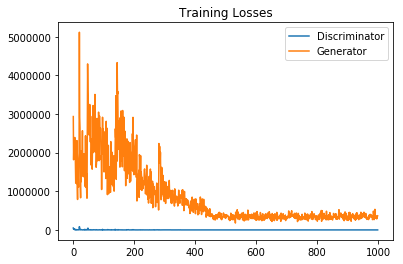

In [13]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

# Test Part

In [ ]:
# TODO: test if discriminator is fooled

In [17]:
print('Accuracy before training')
print('Discriminator benign test accuracy:', (init_benign_test_score <= 0.5).sum() / benign_test.shape[0])
print('Discriminator attack test accuracy:', (init_attack_test_score > 0.5).sum() / attack_test.shape[0])
print('Discriminator total test accuracy:',
      ((init_benign_test_score <= 0.5).sum() + (init_attack_test_score > 0.5).sum()) / (benign_test.shape[0] + attack_test.shape[0]))

Accuracy before training
Discriminator benign test accuracy: 0.11171428571428571
Discriminator attack test accuracy: 0.7314285714285714
Discriminator total test accuracy: 0.4363265306122449


In [18]:
print('Accuracy after training')
print('Discriminator benign test accuracy:', (final_benign_test_score <= 0.5).sum() / benign_test.shape[0])
print('Discriminator attack test accuracy:', (final_attack_test_score > 0.5).sum() / attack_test.shape[0])
print('Discriminator total test accuracy:',
      ((final_benign_test_score <= 0.5).sum() + (final_attack_test_score > 0.5).sum()) / (benign_test.shape[0] + attack_test.shape[0]))

Accuracy after training
Discriminator benign test accuracy: 0.9962857142857143
Discriminator attack test accuracy: 0.8368831168831169
Discriminator total test accuracy: 0.9127891156462585


# Output Visualization

In [16]:
import math

def split_to_two_nearest_factor(x):
    sqrt_x = int(math.sqrt(x))
    i = sqrt_x
    while x % i != 0:
        i -= 1
    return (i, x // i)
fig_size = split_to_two_nearest_factor(input_size)
import numpy as np
import matplotlib.pyplot as plt

fooled = 0

# fig=plt.figure(figsize=(fig_size[0] * 5, fig_size[1] * 5))
# columns = 2
rows = len(original_flows)
for i in range(rows):
#     original_img = original_flows[i][0]
#     generated_img = generated_flows[i][0]
#     ax_original = fig.add_subplot(rows, columns, i * 2 + 1)
#     ax_original.set_title('Epoch {epoch}'.format(epoch=i + 1))
#     plt.imshow(original_img.reshape(fig_size[0],fig_size[1]), cmap='gray')
#     ax_generated = fig.add_subplot(rows, columns, i * 2 + 2)
#     plt.imshow(generated_img.reshape(fig_size[0],fig_size[1]), cmap='gray')
    if attack_scores[i][0] <= 0.5:
#         ax_generated.set_title('Fooled:' + str(attack_scores[i][0]))
        fooled += 1
#     else:
#         ax_generated.set_title('Just close:' + str(attack_scores[i][0]))
# plt.show()
print('Fooled rate:', fooled / len(original_flows))

Fooled rate: 0.01


# Generate attack flows

In [ ]:
#TODO: generate attack flows for Kaihua's discrimination